# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**ОГЛАВЛЕНИЕ**

<a href='#1'>1  Подготовка данных</a>

<a href='#2'>2 Корреляционный анализ</a>

<a href='#3'>3  Обучение моделей</a>

<a href='#4'>3.1  Бустинг LightGBM</a>

<a href='#5'>3.2  Ridge</a>

<a href='#6'>4  Анализ моделей</a>

<a href='#7'>5  Выводы</a>

In [1]:
!pip install phik -q

!pip install scikit-learn==1.1.3 -q

!pip install shap -q

!pip install catboost -q

!pip install missingno -q

In [2]:
import missingno as msno
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

import seaborn as sns
from matplotlib import pyplot as plt

from phik.report import correlation_report, plot_correlation_matrix

from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import(
    Ridge,
    LogisticRegression,
) 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    mean_squared_error,
    roc_curve,
    roc_auc_score,
    f1_score
)

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
    
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split
)

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (StandardScaler, 
                                   OneHotEncoder)
                                  
    

import shap
from sklearn.feature_selection import SelectKBest, f_classif

from shap import Explanation, KernelExplainer
from shap.plots import waterfall, beeswarm

import datetime
from datetime import date
from datetime import time

RANDOM_STATE = 42
TEST_SIZE = 0.25

<a id='1'></a>
## Подготовка данных

In [3]:
try:
    autos = pd.read_csv('/datasets/autos.csv', sep=',', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
    
except:
    autos = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv', sep=',', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])

In [4]:
def data_info(data):
    pd.set_option('display.max_columns', None)
    display(data.head())
    display(data.describe(include='all'))
    data.info()

In [5]:
data_info(autos)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


/tmp/ipykernel_47/2857027859.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(data.describe(include='all'))
/tmp/ipykernel_47/2857027859.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(data.describe(include='all'))
/tmp/ipykernel_47/2857027859.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(data.describe(include='all'))


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.0,354369.000000,354369
unique,271174,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,179150
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,NaN,2016-04-06 13:45:54
freq,7,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,13719,NaN,NaN,17
first,2016-03-05 14:06:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-03-10 00:00:00,NaN,NaN,2016-03-05 14:15:08
last,2016-04-07 14:36:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-04-07 00:00:00,NaN,NaN,2016-04-07 14:58:51
mean,NaN,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,NaN,0.0,50508.689087,NaN
std,NaN,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.726421,NaN,NaN,NaN,NaN,0.0,25783.096248,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

Выведем долю пропущенных значений для каждого столбца датафреймов.

In [6]:
pd.DataFrame(autos.isna().mean()*100)

,0
DateCrawled,0.000000
Price,0.000000
VehicleType,10.579368
RegistrationYear,0.000000
Gearbox,5.596709
Power,0.000000
Model,5.560588
Kilometer,0.000000
RegistrationMonth,0.000000
FuelType,9.282697


В представленном датасете содержатся данные о характеристиках автомобилей и их ценах. Кроме целевого признака - цены, имеется еще 14 признаков. Среди них есть явно неинформативные признаки, которые, скорее всего, не оказывают влияния на цену автомобиля. К ним можно отнести все даты и количество снимков автомобиля. В дальнейшем не будем использовать эти признаки при обучении моделей.

В некоторых колонках датасета имеются пропущенные значения. И количество варьируется от 5.6% до 20%. Пропуски в колонках Gearbox и FuelType можно заполнить наиболее часто встречающимися значениям. Остальные признаки оставим, как есть. Удалять эти строки не будем, так как процент пропусков достаточно высок.

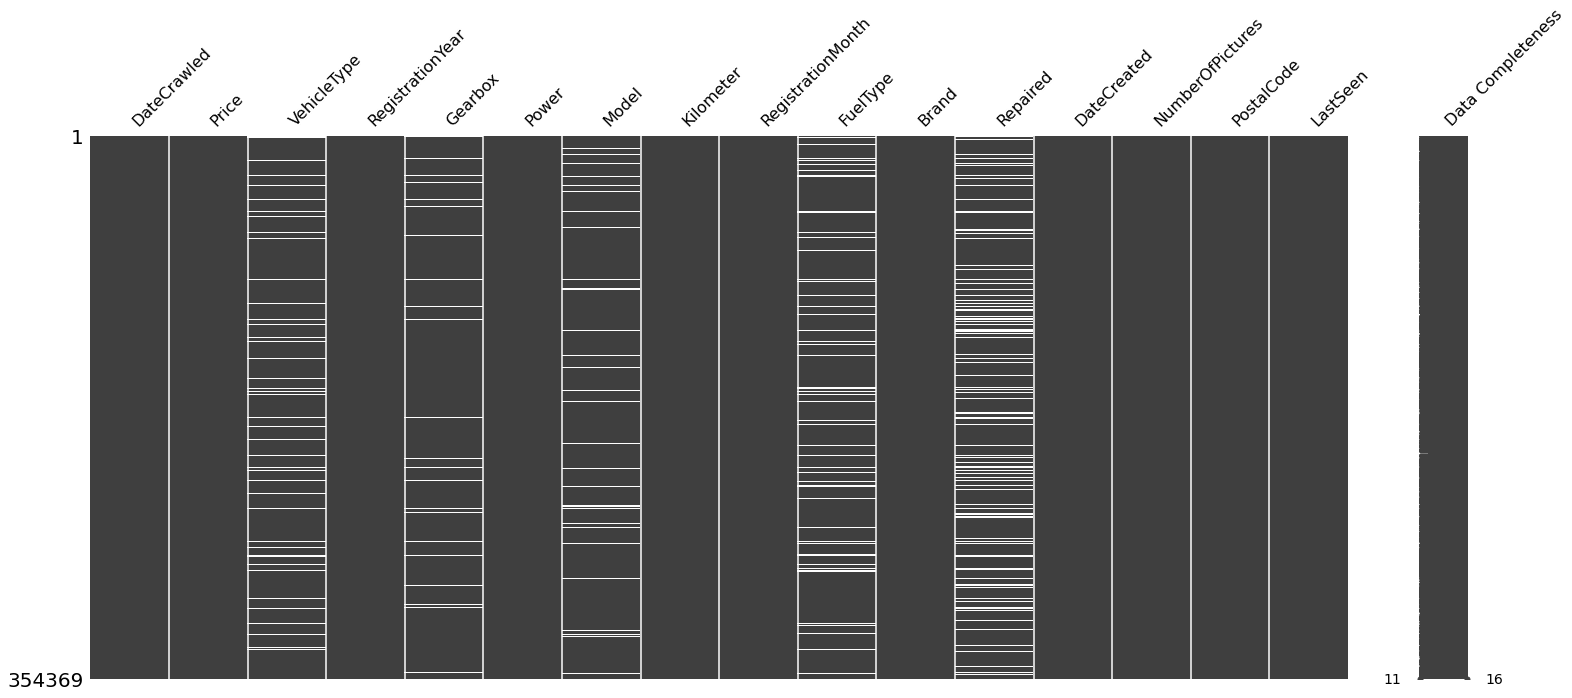

In [7]:
msno.matrix(autos, labels=True)
plt.show()

<AxesSubplot:>

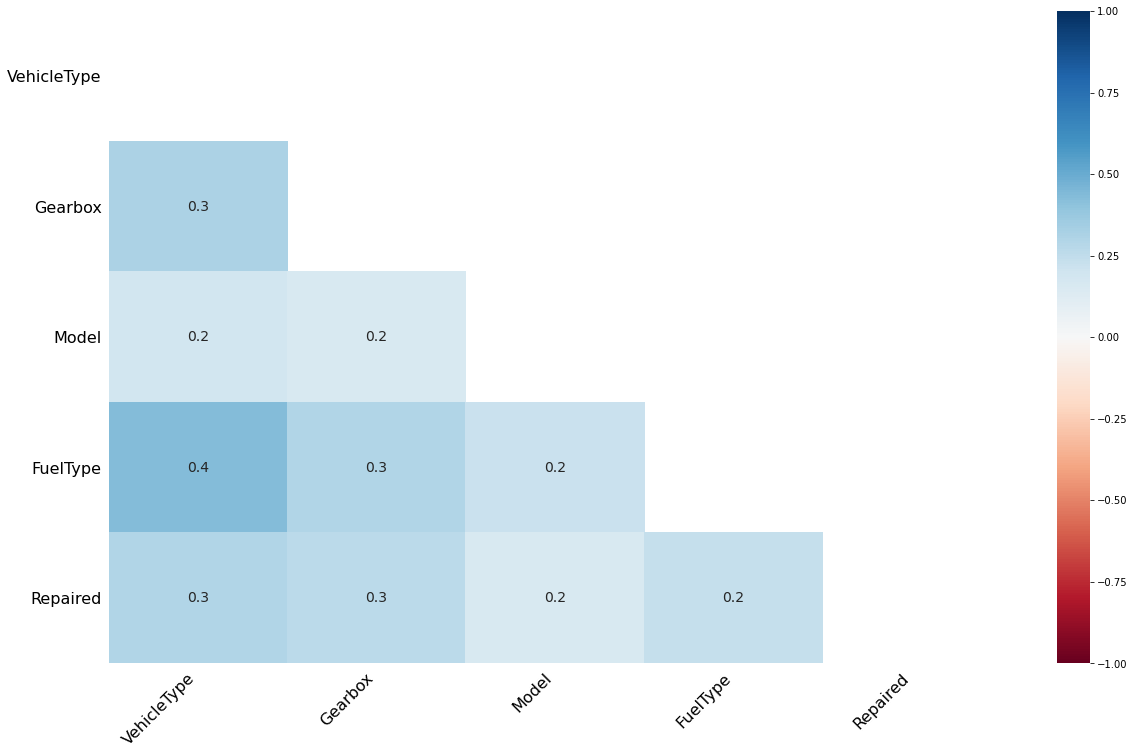

In [8]:
msno.heatmap(autos)

Посмотрим, есть ли строки дубликаты в представленных данных.

In [9]:
autos.duplicated().sum()

4

In [10]:
autos = autos.drop_duplicates().reset_index(drop=True)

In [11]:
autos.duplicated().sum()

0

В данных имеются абсолютные дубликаты - 4 строки. Удалим их.

Выведем уникальные категориальных значения признаков.

In [12]:
autos['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [13]:
autos['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [14]:
autos['Model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

In [15]:
autos['Model'].nunique()

250

In [16]:
autos['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [17]:
autos['FuelType'] = np.where(autos['FuelType'] == 'gasoline', 'petrol', autos['FuelType'])

In [18]:
autos['Brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

In [19]:
autos['Repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

In [20]:
autos['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

In [21]:
len(autos.query('RegistrationYear <= 1950 or RegistrationYear >= 2026'))

369

При анализе уникальных значений признаков обнаружены некорректные значения года выпуска. Поскольку таких строк - всего 369, избавимся от таких данных.

In [24]:
print('Самая поздняя дата:', autos['DateCreated'].dt.year.max())

Самая поздняя дата: 2016


Удаление неинформативных столбцов.

In [25]:
autos.drop(['DateCrawled'], axis = 1, inplace = True)
autos.drop(['DateCreated'], axis = 1, inplace = True)
autos.drop(['LastSeen'], axis = 1, inplace = True)
autos.drop(['NumberOfPictures'], axis = 1, inplace = True)
autos.drop(['RegistrationMonth'], axis = 1, inplace = True)
autos.drop(['PostalCode'], axis = 1, inplace = True)

In [26]:
autos = autos.query('RegistrationYear > 1950 and RegistrationYear < 2017').reset_index(drop=True)

In [27]:
autos['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 2016,
       2007, 2009, 2002, 1997, 1990, 1981, 2003, 1994, 1991, 1984, 2006,
       1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989, 2015, 1982,
       1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988, 1970, 1965, 1974,
       1979, 1955, 1978, 1972, 1968, 1977, 1961, 1960, 1966, 1975, 1963,
       1964, 1954, 1958, 1967, 1959, 1956, 1962, 1957, 1951, 1953, 1952])

In [28]:
autos.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,petrol,audi,yes
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no


Проведем краткий анализ данных.

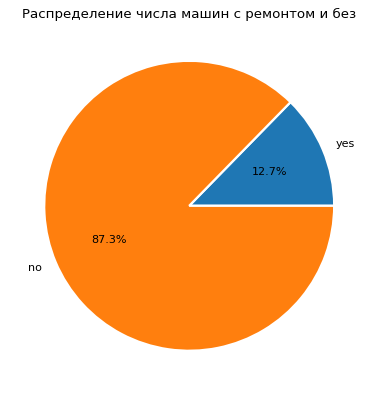

In [29]:
n1 = autos[autos['Repaired'] == 'yes']['Repaired'].count()
n2 = autos[autos['Repaired'] == 'no']['Repaired'].count()
plt.figure(figsize=(10,6), dpi= 80)
plt.pie([n1, n2], labels=['yes', 'no'], wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white'}, autopct='%.1f%%')
plt.title('Распределение числа машин с ремонтом и без')
plt.show()

В основном, в датасете присутствуют неремонтировавшиеся машины - 87%.

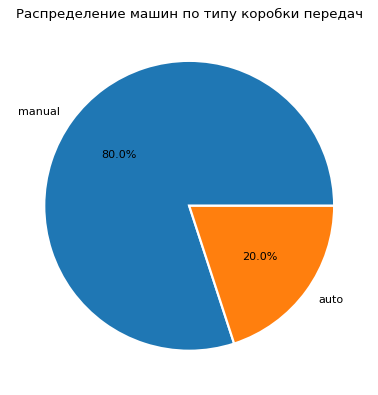

In [30]:
n1 = autos[autos['Gearbox'] == 'manual']['Gearbox'].count()
n2 = autos[autos['Gearbox'] == 'auto']['Gearbox'].count()
plt.figure(figsize=(10,6), dpi= 80)
plt.pie([n1, n2], labels=['manual', 'auto'], wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white'}, autopct='%.1f%%')
plt.title('Распределение машин по типу коробки передач')
plt.show()

В основном, в датасете присутствуют машины с ручной коробкой передач.

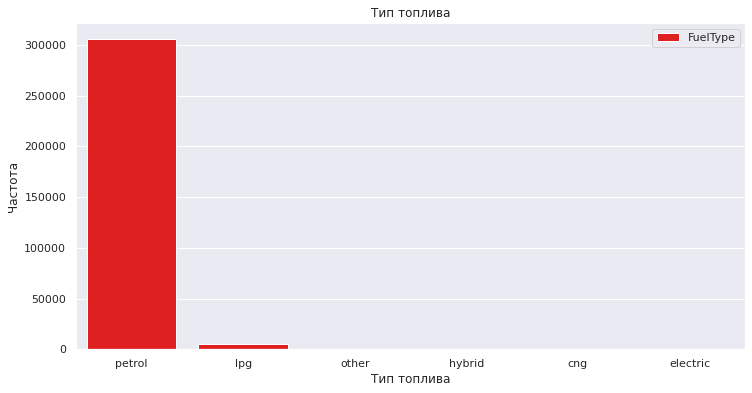

In [31]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.countplot(data=autos, x="FuelType", color="red", label="FuelType")

plt.ylabel('Частота')
plt.xlabel('Тип топлива')
plt.title('Тип топлива')
plt.legend() 
plt.show()

Большинство машин использует бензин.

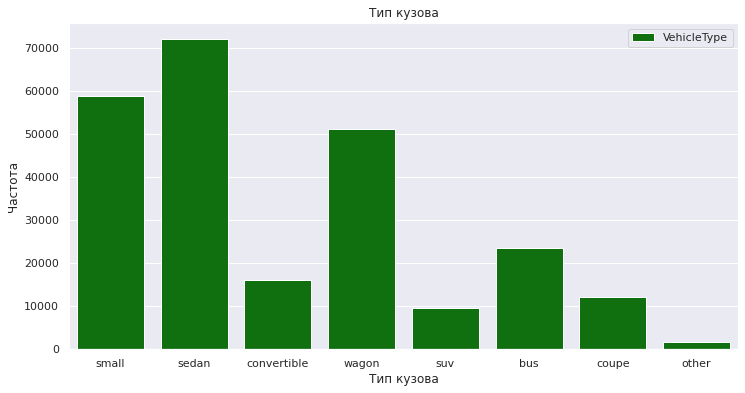

In [32]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.countplot(data=autos.dropna(), x="VehicleType", color="green", label="VehicleType")

plt.ylabel('Частота')
plt.xlabel('Тип кузова')
plt.title('Тип кузова')
plt.legend() 
plt.show()

Наиболее часто встречающийся тип кузова - седан.

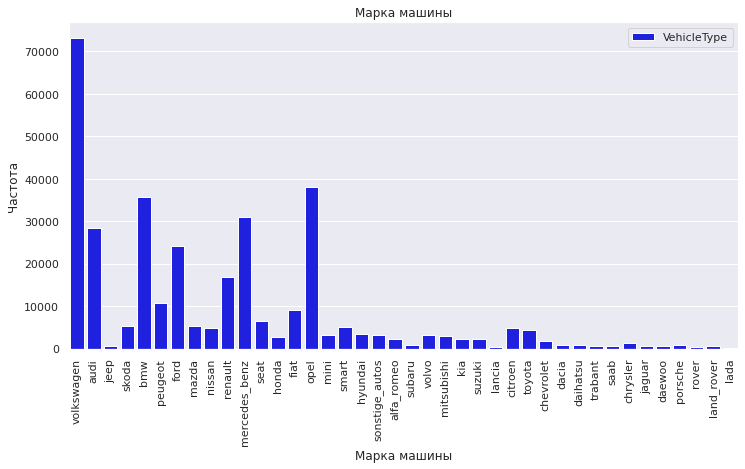

In [33]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.countplot(data=autos, x="Brand", color="blue", label="VehicleType")

plt.xticks(rotation=90)
plt.ylabel('Частота')
plt.xlabel('Марка машины')
plt.title('Марка машины')
plt.legend() 
plt.show()

Наиболее часто встречающиеся марки машин - фольксваген, мерседес и BMW.

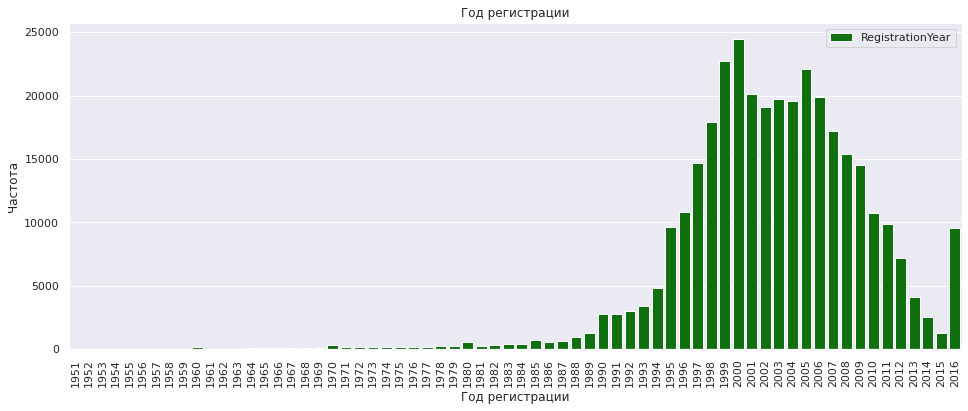

In [34]:
plt.figure(figsize=(16,6))
sns.set_theme(style="darkgrid")

sns.countplot(data=autos, x="RegistrationYear", color="green", label="RegistrationYear")

plt.xticks(rotation=90)
plt.ylabel('Частота')
plt.xlabel('Год регистрации')
plt.title('Год регистрации')
plt.legend() 
plt.show()

В основном, машины регистрировались между 1995 и 2016 годами. Но есть и довольно старые - 1960 года.

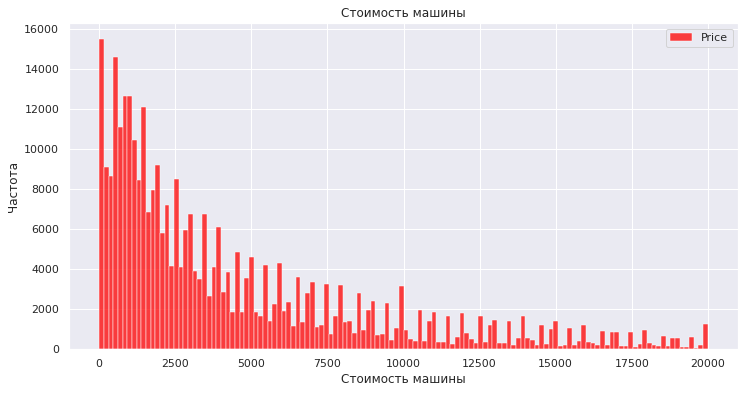

In [35]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=autos, x="Price", color="red", label="Price")

plt.ylabel('Частота')
plt.xlabel('Стоимость машины')
plt.title('Стоимость машины')
plt.legend() 
plt.show()

Распределение целевого признака - цены, не является симметричным. Пик распределения сдвинут влево, имеется длинный хвост, соответствующий дорогим машинам. Возможно, что такие машины лучше выделять в отдельный датасет и  обучать для них отдельную модель. Для таких машин будут работать совершенно другие закономерности: более старые и ремонтированные машины могут стоить дороже, что не будет выполняться для машин из среднего ценового сегмента.

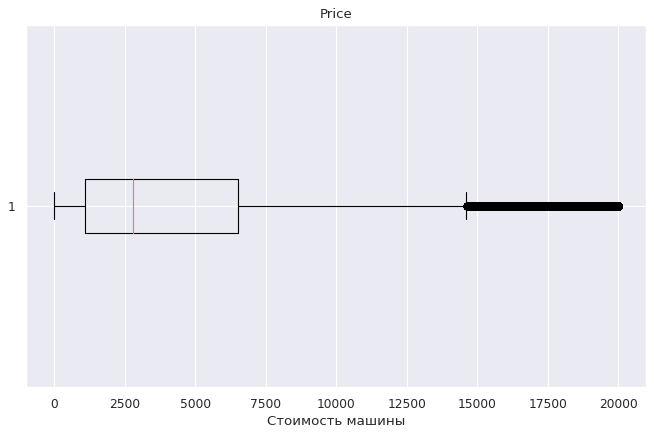

In [36]:
plt.figure(figsize=(10,6), dpi= 80)
plt.boxplot(autos['Price'], vert=False)
plt.title('Price')
plt.xlabel('Стоимость машины')
plt.show()

Сосчитаем процент очень дорогих машин во всем датафрейме.

In [37]:
100*autos[autos['Price'] > 13000]['Price'].count()/len(autos)

7.145486510921133

Таких данных довольно много - около 7%. Поэтому не будем их выбрасывать.

In [38]:
100*autos[autos['Price'] == 0]['Price'].count()/len(autos)

2.931051238179939

В данных присутствует 3% машин с нулевой ценой. Смысл этого непонятен, поэтому выбросим эти строки.

In [39]:
autos.query('Price == 0')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
37,0,NaN,1990,NaN,0,corsa,150000,petrol,opel,NaN
107,0,small,1999,NaN,0,NaN,5000,petrol,volkswagen,NaN
144,0,bus,2004,manual,101,meriva,150000,lpg,opel,yes
146,0,NaN,2006,NaN,0,other,5000,NaN,fiat,NaN
...,...,...,...,...,...,...,...,...,...,...
339409,0,NaN,2000,manual,65,corsa,150000,NaN,opel,yes
339442,0,small,2002,manual,60,fiesta,150000,petrol,ford,NaN
339452,0,small,1999,manual,53,swift,150000,petrol,suzuki,NaN
339480,0,small,1999,manual,37,arosa,150000,petrol,seat,yes


In [40]:
autos = autos.query('Price != 0').reset_index(drop=True)

Разделим признаки на числовые и категориальные.

In [41]:
num_col = ['Price', 'Power', 'Kilometer']
cat_col = ['VehicleType', 'RegistrationYear', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

<a id='2'></a>
## Корреляционный анализ

Построим матрицу корреляций Phi_K.

In [42]:
data_phik = autos.phik_matrix(interval_cols = num_col)
display(data_phik)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
Price,1.000000,0.272381,0.671891,0.329913,0.005842,0.583271,0.309406,0.045985,0.362872,0.374744
VehicleType,0.272381,1.000000,0.266733,0.289468,0.012131,0.917638,0.174159,0.082674,0.633895,0.081048
RegistrationYear,0.671891,0.266733,1.000000,0.140935,0.027790,0.684463,0.622377,0.120082,0.385208,0.220572
Gearbox,0.329913,0.289468,0.140935,1.000000,0.011193,0.648568,0.020372,0.106475,0.523627,0.041374
Power,0.005842,0.012131,0.027790,0.011193,1.000000,0.000000,0.012060,0.013566,0.001827,0.012273
Model,0.583271,0.917638,0.684463,0.648568,0.000000,1.000000,0.443264,0.373097,0.998362,0.154875
Kilometer,0.309406,0.174159,0.622377,0.020372,0.012060,0.443264,1.000000,0.081637,0.284866,0.111589
FuelType,0.045985,0.082674,0.120082,0.106475,0.013566,0.373097,0.081637,1.000000,0.256640,0.020979
Brand,0.362872,0.633895,0.385208,0.523627,0.001827,0.998362,0.284866,0.256640,1.000000,0.102690
Repaired,0.374744,0.081048,0.220572,0.041374,0.012273,0.154875,0.111589,0.020979,0.102690,1.000000


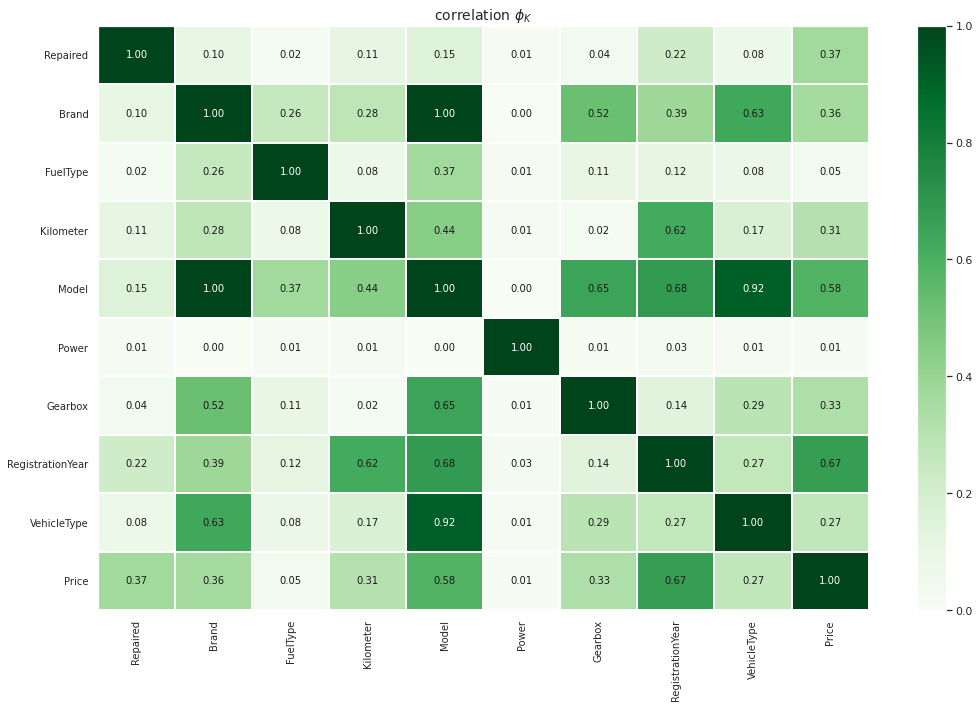

In [43]:
plot_correlation_matrix(data_phik.values, 
                        x_labels=data_phik.columns, 
                        y_labels=data_phik.index,
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(15, 10))

Из матрицы корреляций видно, что некоторые признаки являются мультиколлинеарными. Коэффициент корреляции - 0.89 и выше. Это может стать проблемой при использовании линейных моделей. Чтобы избежать этого, воспользуемся Гребневой регрессией или ридж-регрессией (ridge regression — один из методов понижения размерности). Ridge применяется для борьбы с избыточностью данных, когда независимые переменные коррелируют друг с другом, вследствие чего проявляется неустойчивость оценок коэффициентов многомерной линейной регрессии.

В качестве второй модели будем использовать градиентный бустинг LightGBM, что требуется по условию задачи. 

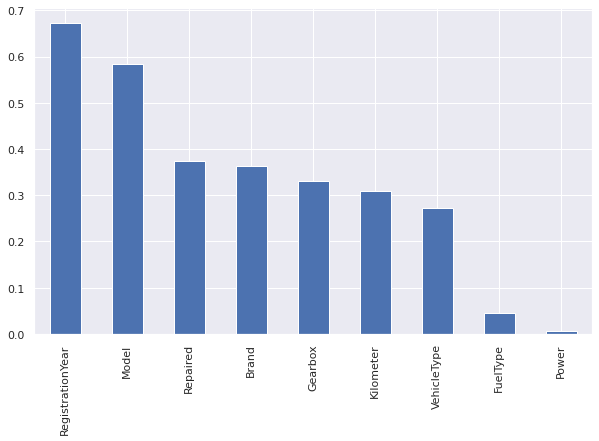

In [44]:
plt.figure(figsize=(10, 6))
_ = data_phik['Price'].sort_values(ascending=False)[1:].plot(kind='bar')

Самая высокая корреляция наблюдается между целевым признаком Ценой и Годом регистрации, а также Моделью. С остальными признаками наблюдается более низкая корреляция.

In [45]:
list = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

In [46]:
autos[list] = autos[list].astype('category')

<a id='3'></a>
## Обучение моделей

<a id='4'></a>
### Бустинг LightGBM

В качестве первой модели используем градиентный бустинг LightGBM.

Разобъем датасет на выборки.

In [47]:
Y = autos['Price']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
autos.drop(['Price'], axis=1),
Y,
test_size = TEST_SIZE,
random_state = RANDOM_STATE
)

In [50]:
#Замена пропущенных значений в столбце "FuelType" на наиболее часто встречающееся значение
mode_fuel_type = autos['FuelType'].mode()[0]  # Вычисление моды (наиболее часто встречающегося значения)
X_train['FuelType'].fillna(mode_fuel_type, inplace=True)

In [52]:
#Замена пропущенных значений в столбце "Gearbox" на наиболее часто встречающееся значение
mode_gearbox = autos['Gearbox'].mode()[0]  # Вычисление моды (наиболее часто встречающегося значения)
X_train['Gearbox'].fillna(mode_gearbox, inplace=True)

In [53]:
X_train

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
169171,sedan,2006,auto,329,7er,150000,petrol,bmw,NaN
28907,wagon,2007,manual,174,clubman,90000,petrol,mini,no
305304,sedan,2000,auto,163,c_klasse,150000,petrol,mercedes_benz,no
205138,wagon,2003,manual,131,passat,150000,petrol,volkswagen,no
290212,convertible,2001,manual,220,boxster,125000,petrol,porsche,no
...,...,...,...,...,...,...,...,...,...
119879,wagon,2004,manual,84,ducato,150000,petrol,fiat,no
259178,small,2010,manual,69,justy,70000,petrol,subaru,no
131932,other,2011,manual,143,1er,40000,petrol,bmw,no
146867,sedan,1992,manual,109,other,150000,petrol,mercedes_benz,no


Укажем, что используем категориальные признаки напрямую.

In [54]:
fit_params={'categorical_feature': 'auto'}

Для оценки качества моделей будем использовать метрику RMSE. RMSE представляет собой квадратный корень из среднего квадрата разности между прогнозируемыми и наблюдаемыми результатами.

In [55]:
model_1 = LGBMRegressor()

In [56]:
grid_searcher = GridSearchCV(model_1,
                             param_grid={'num_leaves': range(31, 41, 10),
                                         #'min_data_in_leaf': [1],
                                         'max_depth': [-1],
                                         'n_estimators': [100, 200]},
                             cv=5,
                            scoring='neg_root_mean_squared_error',
                            error_score='raise',
                            refit=True,
                            n_jobs=-1)

In [57]:
len(y_train)

247213

In [58]:
%%time
grid_searcher.fit(X_train, y_train, **fit_params)

CPU times: user 1min 22s, sys: 399 ms, total: 1min 22s
Wall time: 1min 23s


GridSearchCV(cv=5, error_score='raise', estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'max_depth': [-1], 'n_estimators': [100, 200],
                         'num_leaves': range(31, 41, 10)},
             scoring='neg_root_mean_squared_error')

In [59]:
print ('Метрика лучшей модели на кросс-валидации:', -1*grid_searcher.best_score_)

Метрика лучшей модели на кросс-валидации: 1621.3934111193776


In [60]:
best_model = grid_searcher.best_estimator_

In [61]:
print(grid_searcher.best_params_)

{'max_depth': -1, 'n_estimators': 200, 'num_leaves': 31}


In [62]:
%%time
y_pred_train = best_model.predict(X_train)

CPU times: user 4.63 s, sys: 71.9 ms, total: 4.7 s
Wall time: 4.67 s


In [63]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
print('Метрика лучшей модели на тренировочной выборке:', round(rmse_train, 2))

Метрика лучшей модели на тренировочной выборке: 1546.42


In [64]:
print('Время, затраченное на повторную подгонку (refit) модели:', grid_searcher.refit_time_)

Время, затраченное на повторную подгонку (refit) модели: 9.594667673110962


In [65]:
grid_searcher.cv_results_

{'mean_fit_time': array([4.55811687, 8.68006024]),
 'std_fit_time': array([0.12529078, 1.63186665]),
 'mean_score_time': array([0.56662655, 1.0181272 ]),
 'std_score_time': array([0.04519305, 0.03612457]),
 'param_max_depth': masked_array(data=[-1, -1],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[100, 200],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_num_leaves': masked_array(data=[31, 31],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': -1, 'n_estimators': 100, 'num_leaves': 31},
  {'max_depth': -1, 'n_estimators': 200, 'num_leaves': 31}],
 'split0_test_score': array([-1635.01974176, -1597.19057965]),
 'split1_test_score': array([-1676.20478821, -1642.21976406]),
 'split2_test_score': array([-1661.38617759, -1625.54537894]),
 'split3_test_score': array([-1655.0443074 , -1620.26851691]),


<a id='5'></a>
### Ridge

В качестве второй модели используем ридж-регрессию.

In [68]:
num_col = ['Power', 'Kilometer']
cat_col = ['VehicleType', 'RegistrationYear', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

In [69]:
X_train_ridge = X_train.copy()
X_test_ridge = X_test.copy()

Для кодирования и масштабирования используем make_column_transformer. Категориальные признаки закодируем при помощи OneHotEncoder, числовые - при помощи StandardScaler().

In [70]:
col_transformer_ridge = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        cat_col
    ),
    (
        StandardScaler(),
        num_col
    ),
    remainder='passthrough',
    verbose_feature_names_out=False
)


X_train_ridge_1 = pd.DataFrame.sparse.from_spmatrix(
    col_transformer_ridge.fit_transform(X_train_ridge),
    columns=col_transformer_ridge.get_feature_names_out()
)


X_train_ridge_1.head()

,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,VehicleType_nan,RegistrationYear_1952,RegistrationYear_1953,RegistrationYear_1954,RegistrationYear_1955,RegistrationYear_1956,RegistrationYear_1957,RegistrationYear_1958,RegistrationYear_1959,RegistrationYear_1960,RegistrationYear_1961,RegistrationYear_1962,RegistrationYear_1963,RegistrationYear_1964,RegistrationYear_1965,RegistrationYear_1966,RegistrationYear_1967,RegistrationYear_1968,RegistrationYear_1969,RegistrationYear_1970,RegistrationYear_1971,RegistrationYear_1972,RegistrationYear_1973,RegistrationYear_1974,RegistrationYear_1975,RegistrationYear_1976,RegistrationYear_1977,RegistrationYear_1978,RegistrationYear_1979,RegistrationYear_1980,RegistrationYear_1981,RegistrationYear_1982,RegistrationYear_1983,RegistrationYear_1984,RegistrationYear_1985,RegistrationYear_1986,RegistrationYear_1987,RegistrationYear_1988,RegistrationYear_1989,RegistrationYear_1990,RegistrationYear_1991,RegistrationYear_1992,RegistrationYear_1993,RegistrationYear_1994,RegistrationYear_1995,RegistrationYear_1996,RegistrationYear_1997,RegistrationYear_1998,RegistrationYear_1999,RegistrationYear_2000,RegistrationYear_2001,RegistrationYear_2002,RegistrationYear_2003,RegistrationYear_2004,RegistrationYear_2005,RegistrationYear_2006,RegistrationYear_2007,RegistrationYear_2008,RegistrationYear_2009,RegistrationYear_2010,RegistrationYear_2011,RegistrationYear_2012,RegistrationYear_2013,RegistrationYear_2014,RegistrationYear_2015,RegistrationYear_2016,Gearbox_manual,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,Model_accord,Model_agila,Model_alhambra,Model_almera,Model_altea,Model_amarok,Model_antara,Model_arosa,Model_astra,Model_auris,Model_avensis,Model_aveo,Model_aygo,Model_b_klasse,Model_b_max,Model_beetle,Model_berlingo,Model_bora,Model_boxster,Model_bravo,Model_c1,Model_c2,Model_c3,Model_c4,Model_c5,Model_c_klasse,Model_c_max,Model_c_reihe,Model_caddy,Model_calibra,Model_captiva,Model_carisma,Model_carnival,Model_cayenne,Model_cc,Model_ceed,Model_charade,Model_cherokee,Model_citigo,Model_civic,Model_cl,Model_clio,Model_clk,Model_clubman,Model_colt,Model_combo,Model_cooper,Model_cordoba,Model_corolla,Model_corsa,Model_cr_reihe,Model_croma,Model_crossfire,Model_cuore,Model_cx_reihe,Model_defender,Model_delta,Model_discovery,Model_doblo,Model_ducato,Model_duster,Model_e_klasse,Model_elefantino,Model_eos,Model_escort,Model_espace,Model_exeo,Model_fabia,Model_fiesta,Model_focus,Model_forester,Model_forfour,Model_fortwo,Model_fox,Model_freelander,Model_fusion,Model_g_klasse,Model_galant,Model_galaxy,Model_getz,Model_gl,Model_glk,Model_golf,Model_grand,Model_i3,Model_i_reihe,Model_ibiza,Model_impreza,Model_insignia,Model_jazz,Model_jetta,Model_jimny,Model_juke,Model_justy,Model_ka,Model_kadett,Model_kaefer,Model_kalina,Model_kalos,Model_kangoo,Model_kappa,Model_kuga,Model_laguna,Model_lancer,Model_lanos,Model_legacy,Model_leon,Model_lodgy,Model_logan,Model_lupo,Model_lybra,Model_m_klasse,Model_m_reihe,Model_materia,Model_matiz,Model_megane,Model_meriva,Model_micra,Model_mii,Model_modus,Model_mondeo,Model_move,Model_musa,Model_mustang,Model_mx_reihe,Model_navara,Model_niva,Model_note,Model_nubira,Model_octavia,Model_omega,Model_one,Model_other,Model_outlander,Model_pajero,Model_panda,Model_passat,Model_phaeton,Model_picanto,Model_polo,Model_primera,Model_ptcruiser,Model_punto,Model_q3,Model_q5,Model_q7,Model_qashqai,Model_r19,Model_range_rover,Model_range_rover_evoque,Model_range_rover_sport,Model_rangerover,Model_rav,Model_rio,Model_roadster,Model_roomster,Model_rx_reihe,Model_s60,Model_s_klasse,Model_s_max,Model_s_type,Model_sa

In [71]:
# трансформируем тестовую выборку
X_test_ridge_1 = pd.DataFrame.sparse.from_spmatrix(
    col_transformer_ridge.transform(X_test_ridge),
    columns=col_transformer_ridge.get_feature_names_out()
)

X_test_ridge_1.head()

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,VehicleType_nan,RegistrationYear_1952,RegistrationYear_1953,RegistrationYear_1954,RegistrationYear_1955,RegistrationYear_1956,RegistrationYear_1957,RegistrationYear_1958,RegistrationYear_1959,RegistrationYear_1960,RegistrationYear_1961,RegistrationYear_1962,RegistrationYear_1963,RegistrationYear_1964,RegistrationYear_1965,RegistrationYear_1966,RegistrationYear_1967,RegistrationYear_1968,RegistrationYear_1969,RegistrationYear_1970,RegistrationYear_1971,RegistrationYear_1972,RegistrationYear_1973,RegistrationYear_1974,RegistrationYear_1975,RegistrationYear_1976,RegistrationYear_1977,RegistrationYear_1978,RegistrationYear_1979,RegistrationYear_1980,RegistrationYear_1981,RegistrationYear_1982,RegistrationYear_1983,RegistrationYear_1984,RegistrationYear_1985,RegistrationYear_1986,RegistrationYear_1987,RegistrationYear_1988,RegistrationYear_1989,RegistrationYear_1990,RegistrationYear_1991,RegistrationYear_1992,RegistrationYear_1993,RegistrationYear_1994,RegistrationYear_1995,RegistrationYear_1996,RegistrationYear_1997,RegistrationYear_1998,RegistrationYear_1999,RegistrationYear_2000,RegistrationYear_2001,RegistrationYear_2002,RegistrationYear_2003,RegistrationYear_2004,RegistrationYear_2005,RegistrationYear_2006,RegistrationYear_2007,RegistrationYear_2008,RegistrationYear_2009,RegistrationYear_2010,RegistrationYear_2011,RegistrationYear_2012,RegistrationYear_2013,RegistrationYear_2014,RegistrationYear_2015,RegistrationYear_2016,Gearbox_manual,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,Model_accord,Model_agila,Model_alhambra,Model_almera,Model_altea,Model_amarok,Model_antara,Model_arosa,Model_astra,Model_auris,Model_avensis,Model_aveo,Model_aygo,Model_b_klasse,Model_b_max,Model_beetle,Model_berlingo,Model_bora,Model_boxster,Model_bravo,Model_c1,Model_c2,Model_c3,Model_c4,Model_c5,Model_c_klasse,Model_c_max,Model_c_reihe,Model_caddy,Model_calibra,Model_captiva,Model_carisma,Model_carnival,Model_cayenne,Model_cc,Model_ceed,Model_charade,Model_cherokee,Model_citigo,Model_civic,Model_cl,Model_clio,Model_clk,Model_clubman,Model_colt,Model_combo,Model_cooper,Model_cordoba,Model_corolla,Model_corsa,Model_cr_reihe,Model_croma,Model_crossfire,Model_cuore,Model_cx_reihe,Model_defender,Model_delta,Model_discovery,Model_doblo,Model_ducato,Model_duster,Model_e_klasse,Model_elefantino,Model_eos,Model_escort,Model_espace,Model_exeo,Model_fabia,Model_fiesta,Model_focus,Model_forester,Model_forfour,Model_fortwo,Model_fox,Model_freelander,Model_fusion,Model_g_klasse,Model_galant,Model_galaxy,Model_getz,Model_gl,Model_glk,Model_golf,Model_grand,Model_i3,Model_i_reihe,Model_ibiza,Model_impreza,Model_insignia,Model_jazz,Model_jetta,Model_jimny,Model_juke,Model_justy,Model_ka,Model_kadett,Model_kaefer,Model_kalina,Model_kalos,Model_kangoo,Model_kappa,Model_kuga,Model_laguna,Model_lancer,Model_lanos,Model_legacy,Model_leon,Model_lodgy,Model_logan,Model_lupo,Model_lybra,Model_m_klasse,Model_m_reihe,Model_materia,Model_matiz,Model_megane,Model_meriva,Model_micra,Model_mii,Model_modus,Model_mondeo,Model_move,Model_musa,Model_mustang,Model_mx_reihe,Model_navara,Model_niva,Model_note,Model_nubira,Model_octavia,Model_omega,Model_one,Model_other,Model_outlander,Model_pajero,Model_panda,Model_passat,Model_phaeton,Model_picanto,Model_polo,Model_primera,Model_ptcruiser,Model_punto,Model_q3,Model_q5,Model_q7,Model_qashqai,Model_r19,Model_range_rover,Model_range_rover_evoque,Model_range_rover_sport,Model_rangerover,Model_rav,Model_rio,Model_roadster,Model_roomster,Model_rx_reihe,Model_s60,Model_s_klasse,Model_s_max,Model_s_type,Model_sa

In [72]:
model_ridge = Ridge(random_state=RANDOM_STATE)

In [74]:
pipeline_ridge = make_pipeline(col_transformer_ridge, model_ridge)

param_grid_ridge = {
    'ridge__alpha': np.arange(0, 0.21, 0.01),
}

In [75]:
gs_ridge_pl = GridSearchCV(
    pipeline_ridge,
    param_grid=param_grid_ridge,
    scoring='neg_root_mean_squared_error',
    error_score='raise',
    refit=True,
    n_jobs=-1
)

In [76]:
%%time
gs_ridge_pl.fit(X_train_ridge, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories

CPU times: user 7min 22s, sys: 5min 54s, total: 13min 16s
Wall time: 13min 18s


GridSearchCV(error_score='raise',
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['VehicleType',
                                                                          'RegistrationYear',
                                                                          'Gearbox',
                                                                          'Model',
                                                                          'FuelType',
                                                                          'Brand',
                                                                          'Repaired']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['Power',
                                                                          'Kilometer'])],
                                                          verbose_feature_names_out=False)),
                                       ('ridge', Ridge(random_state=42))]),
             n_jobs=-1,
             param_grid={'ridge__alpha': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ])},
             scoring='neg_root_mean_squared_error')

In [77]:
gs_ridge_best_score = gs_ridge_pl.best_score_ * -1
gs_ridge_best_params = gs_ridge_pl.best_params_

In [78]:
# лучшее значение RMSE на кросс-валидации
print(f'best_score: {gs_ridge_best_score}')
# лучшие гиперпараметры
print(f'best_params: {gs_ridge_best_params}')

best_score: 2274.7592238765856
best_params: {'ridge__alpha': 0.04}


In [79]:
print('Время, затраченное на повторную подгонку (refit) модели:', gs_ridge_pl.refit_time_)

Время, затраченное на повторную подгонку (refit) модели: 7.839056015014648


In [80]:
gs_ridge_pl.cv_results_

{'mean_fit_time': array([6.7505609 , 6.74619594, 6.96021962, 7.49684443, 7.58548656,
        7.14217701, 7.1219882 , 7.01536169, 6.93573995, 6.53224931,
        7.7029705 , 7.70113077, 7.42298784, 7.64124436, 7.69270506,
        7.06628633, 7.49382634, 7.19025331, 7.76365194, 7.21799011,
        7.27651696]),
 'std_fit_time': array([0.2812103 , 0.64419398, 0.62849365, 0.46617356, 0.40539386,
        0.59890891, 0.37334294, 0.27982466, 0.39000149, 0.71879237,
        0.30404939, 0.12034756, 0.56195435, 0.36257218, 0.14868338,
        0.41403827, 0.20511258, 0.59141398, 0.15602706, 0.37432502,
        0.48227008]),
 'mean_score_time': array([0.26793842, 0.24573326, 0.25937376, 0.30141435, 0.27218652,
        0.25864506, 0.24601607, 0.25843968, 0.2962184 , 0.27685838,
        0.26205764, 0.27884059, 0.27293739, 0.27903609, 0.26588502,
        0.27362494, 0.27092934, 0.27895508, 0.27750549, 0.28012729,
        0.27927718]),
 'std_score_time': array([0.0406038 , 0.0390327 , 0.03161036, 0.00

In [81]:
best_model_r = gs_ridge_pl.best_estimator_

In [82]:
%%time
y_pred_train_r = best_model_r.predict(X_train_ridge)

CPU times: user 506 ms, sys: 0 ns, total: 506 ms
Wall time: 504 ms


In [83]:
rmse_train_r = mean_squared_error(y_train, y_pred_train_r, squared=False)
print('Метрика лучшей модели на тренировочной выборке:', round(rmse_train_r, 2))

Метрика лучшей модели на тренировочной выборке: 2269.31


In [86]:
%%time
y_pred_test = best_model.predict(X_test)

CPU times: user 1.6 s, sys: 0 ns, total: 1.6 s
Wall time: 1.57 s


In [87]:
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print('Метрика лучшей модели на тестовой выборке:', round(rmse_test, 2))

Метрика лучшей модели на тестовой выборке: 1659.65


<a id='6'></a>
## Анализ моделей

В качестве первой модели используем градиентный бустинг LightGBM.
Для оценки качества моделей будем использовать метрику RMSE. RMSE представляет собой квадратный корень из среднего квадрата разности между прогнозируемыми и наблюдаемыми результатами.
Лучшие параметры модели: 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 31.
Метрика лучшей модели на тренировочной выборке: 1546.4.
Время обучения модели – 1 мин 22 с, время предсказания модели – 4.7 с.

В качестве второй модели используем ридж-регрессию.
Для кодирования и масштабирования используем make_column_transformer. Категориальные признаки закодируем при помощи OneHotEncoder, числовые - при помощи StandardScaler().
Лучшие параметры модели: alpha: 0.04
Метрика лучшей модели на тренировочной выборке: 2269.3.
Время обучения модели – 13 мин 16 с, время предсказания модели – 506 мс.

Обе модели удовлетворяют условию: значение метрики RMSE должно быть меньше 2500. Однако бустинг показал себя лучше, как с точки зрения значения метрики (она ниже: 1546.4 против 2269.3 на тренировочной выборке), так и с точки зрения затрачиваемого времени (оно значительно ниже: около 1.5 мин против 13 мин.)

Метрика лучшей модели (градиентный бустинг LightGBM) на тестовой выборке: 1659.65 (<2500). 

<a id='7'></a>
## Выводы

В представленном датасете содержатся данные о характеристиках автомобилей и их ценах. Кроме целевого признака - цены, имеется еще 14 признаков. Среди них есть явно неинформативные признаки, которые, скорее всего, не оказывают влияния на цену автомобиля. К ним можно отнести все даты и количество снимков автомобиля. В дальнейшем не будем использовать эти признаки при обучении моделей.


В некоторых колонках датасета имеются пропущенные значения. И количество варьируется от 5.6% до 20%. Пропуски в колонках Gearbox и FuelType можно заполнить наиболее часто встречающимися значениям. Остальные признаки оставим, как есть. Удалять эти строки не будем, так как процент пропусков достаточно высок.
В данных имеются абсолютные дубликаты - 4 строки. Удалим их.
При анализе уникальных значений признаков обнаружены некорректные значения года выпуска. Поскольку таких строк - всего 369, избавимся от таких данных.
Анализ представленных данных показывает следующее:
В основном, в датасете присутствуют неремонтировавшиеся машины - 87%.
В основном, в датасете присутствуют машины с ручной коробкой передач.
Большинство машин использует бензин.
Наиболее часто встречающийся тип кузова - седан.
Наиболее часто встречающиеся марки машин - фольксваген, мерседес и BMW.
В основном, машины регистрировались между 1995 и 2019 годами. Но есть и довольно старые - 1960 года.


Распределение целевого признака - цены, не является симметричным. Пик распределения сдвинут влево, имеется длинный хвост, соответствующий дорогим машинам. Возможно, что такие машины лучше выделять в отдельный датасет и  обучать для них отдельную модель. Для таких машин будут работать совершенно другие закономерности: более старые и ремонтированные машины могут стоить дороже, что не будет выполняться для машин из среднего ценового сегмента.
В данных присутствует 3% машин с нулевой ценой. Смысл этого непонятен, поэтому выбросим эти строки.


Из матрицы корреляций видно, что некоторые признаки являются мультиколлинеарными. Коэффициент корреляции - 0.89 и выше. Это может стать проблемой при использовании линейных моделей. Чтобы избежать этого, воспользуемся Гребневой регрессией или ридж-регрессией (ridge regression — один из методов понижения размерности). Ridge применяется для борьбы с избыточностью данных, когда независимые переменные коррелируют друг с другом, вследствие чего проявляется неустойчивость оценок коэффициентов многомерной линейной регрессии.
В качестве второй модели будем использовать градиентный бустинг LightGBM, что требуется по условию задачи.


Самая высокая корреляция наблюдается между целевым признаком Ценой и Годом регистрации, а также Моделью. С остальными признаками наблюдается более низкая корреляция.


В качестве первой модели используем градиентный бустинг LightGBM.
Для оценки качества моделей будем использовать метрику RMSE. RMSE представляет собой квадратный корень из среднего квадрата разности между прогнозируемыми и наблюдаемыми результатами.
Лучшие параметры модели: 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 31.
Метрика лучшей модели на тренировочной выборке: 1546.4.
Время обучения модели – 1 мин 22 с, время предсказания модели – 4.7 с.


В качестве второй модели используем ридж-регрессию.
Для кодирования и масштабирования используем make_column_transformer. Категориальные признаки закодируем при помощи OneHotEncoder, числовые - при помощи StandardScaler().
Лучшие параметры модели: alpha: 0.04
Метрика лучшей модели на тренировочной выборке: 2269.3.
Время обучения модели – 13 мин 16 с, время предсказания модели – 506 мс.


Обе модели удовлетворяют условию: значение метрики RMSE должно быть меньше 2500. Однако бустинг показал себя лучше, как с точки зрения значения метрики (она ниже: 1546.4 против 2269.3 на тренировочной выборке), так и с точки зрения затрачиваемого времени (оно значительно ниже: около 1.5 мин против 13 мин.)



Метрика лучшей модели (градиентный бустинг LightGBM) на тестовой выборке: 1659.65 (<2500).


## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей